# Importing the modules


In [3]:
import os
import pandas as pd
import lyricsgenius as lg
import spotipy
import time
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

In [2]:
pip install lyricsgenius 

Note: you may need to restart the kernel to use updated packages.


# Access Tokens

In [4]:
spotipy_client_id = 'c3e43077142f4e7bb70601747bd1f0d2'
spotipy_client_secret = '925f7025c8e6420f9be665401784c0f6'
spotipy_redirect_uri = 'https://google.com'
genius_access_token = 'jVHnDFkBvrvEsj_M8YUxbQ9t8mo2zIG19giBxlX_g7NeRz4W51gedM1YHTBX_U-4'

In [21]:
df = pd.read_excel('music.xlsx')

In [8]:
df['sentiment'].value_counts()

neg    50
pos    50
Name: sentiment, dtype: int64

In [9]:
df.head(3)

,Unnamed: 0,artists,tracks,sentiment,lyrics
0,0,Morgan Heritage,Don't Haffi Dread,neg,"Don’t Haffi Dread LyricsYeah, yeah, yeah - rag..."
1,1,Whitney Houston,My Love Is Your Love,pos,My Love is Your Love Lyrics[Intro: Background ...
2,2,Coro,Can't Let You Go,pos,Can’t Let You Go LyricsYeah\n\nI shoulda known...


In [22]:
df=df[['artists','tracks','sentiment','lyrics']]

# Plotting

Text(0.5, 0, 'Sentiments')

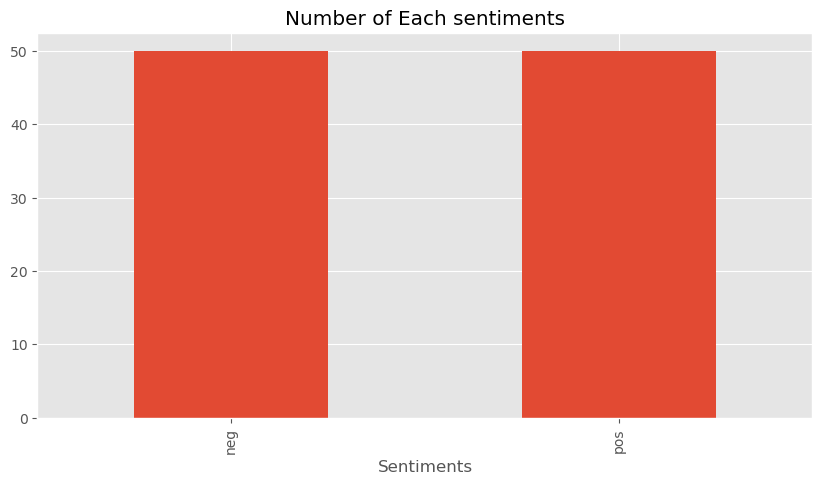

In [12]:
graph = df['sentiment'].value_counts().sort_index().plot(kind='bar',title='Number of Each sentiments',figsize=(10,5))
graph.set_xlabel('Sentiments')

# Genius API

In [13]:
genius = lg.Genius(genius_access_token)


In [ ]:
l=[]
for i in range(len(df['tracks'])):
  song = genius.search_song(title=df['tracks'][i],artist=df['artists'][i])
  if song != None:
    lyrics = song.lyrics
    l.append(lyrics)
  else:
    l.append(None)

lyrics_df = pd.DataFrame()
lyrics_df['lyrics'] = l

In [ ]:
# join both data frames
df = pd.concat([df, lyrics_df], axis=1, join='inner')
df.head()

In [ ]:
# save data frame to excel
df.to_excel('music.xlsx')

# <b>Data Preprocessing</b>

### <b>1.Data Cleaning</b>

#### Checking for missing values


In [23]:
df.isna().sum()

artists      0
tracks       0
sentiment    0
lyrics       2
dtype: int64

In [24]:
df.dropna(how='any',inplace=True)

#### Checking for Duplicate values

In [26]:
df['tracks'].duplicated().sum()


1

In [27]:
df.drop_duplicates(subset='tracks',keep='last',inplace=True)


In [28]:
df['sentiment'].value_counts()

neg    49
pos    48
Name: sentiment, dtype: int64

### <b>2.Tokenization</b>

In [29]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nehaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
def preprocessText(text, remove_stops=False):
    
    # Remove everything between hard brackets
    text = re.sub(pattern="\[.+?\]( )?", repl='', string=text)

    # Change "walkin'" to "walking", for example
    text = re.sub(pattern="n\\\' ", repl='ng ', string=text)

    # Remove x4 and (x4), for example
    text = re.sub(pattern="(\()?x\d+(\))?", repl=' ', string=text)

    # Fix apostrophe issues
    text= re.sub(pattern="\\x91", repl="'", string=text)
    text = re.sub(pattern="\\x92", repl="'", string=text)
    text= re.sub(pattern="<u\+0092>", repl="'", string=text)
    
    # Make lowercase
    text = text.lower()

    # Remove \n from beginning
    text = re.sub(pattern='^\n', repl=' ', string=text)

    # Strip , ! ?, : and remaining \n from lyrics
    text = ''.join([char.strip(",!?:") for char in text])
    text = text.replace('\n', '  ')
    
    # Remove contractions
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"won\’t", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"let\’s", "let us", text)
    text = re.sub(r"ain't", "aint", text)
    text = re.sub(r"ain\’t", "aint", text)
    text = re.sub(r"wanna", "want to", text)
    text = re.sub(r"gonna", "going to", text)
    text = re.sub(r"gotta", "go to", text)
    
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\’s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)
    text = re.sub(r"\â", "a", text)
    
    # Remove Symbols
    text = re.sub(r"[^\w\s]","", text)
    
    # remove single char
    text = re.sub(r"\b[a-zA-Z]\b","", text)
   
    #remove number
    text = re.sub(r"\d+", "", text)
    
    #remove duplicate char(oohhh,ohhhh,oohhhh,etc)
    text = re.sub(r"o+h", "oh", text)
    text = re.sub(r"oh+", "", text)
    
    # Remove remaining punctuation
    punc = string.punctuation
    text = ''.join([char for char in text if char not in punc])

    # Remove double spaces and beginning/trailing whitespace
    text = re.sub(pattern='( ){2,}', repl=' ', string=text)
    text = text.strip()
    
    return(text)

df['lyrics'] = df['lyrics'].apply(preprocessText)

### <b>3.Stopwords Removal</b>

In [31]:
import neattext.functions as nfx


In [32]:
df['lyrics'] = df['lyrics'].apply(nfx.remove_stopwords)

In [33]:
df.head(3)

,artists,tracks,sentiment,lyrics
0,Morgan Heritage,Don't Haffi Dread,neg,haffi dread lyricsyeah yeah yeah ragga ragga h...
1,Whitney Houston,My Love Is Your Love,pos,love love lyrics clap hands yall alright turn ...
2,Coro,Can't Let You Go,pos,let lyricsyeah shoulda known way serves right ...


# Vader Algorithm

In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

sentiment_list = []
sentiment_score_list = []

for i in df['lyrics']:
    try:
        sentiment_score = analyser.polarity_scores(i)

        if sentiment_score['compound'] >= 0.2:
            sentiment_percentage = sentiment_score['compound']
            sentiment = 'Positive'
        elif sentiment_score['compound'] > -0.2 and sentiment_score['compound'] < 0.2:
            sentiment_percentage = sentiment_score['compound']
            sentiment = 'Neutral'
        elif sentiment_score['compound'] <= -0.2:
            sentiment_percentage = sentiment_score['compound']
            sentiment = 'Negative'

        sentiment_list.append(sentiment)
        sentiment_score_list.append((abs(sentiment_percentage) * 100))
        
    except:
        sentiment_list.append('None')
        sentiment_score_list.append(0)

df['vader_sentiment'] = sentiment_list


In [35]:
df.vader_sentiment.value_counts()

Positive    63
Negative    32
Neutral      2
Name: vader_sentiment, dtype: int64

In [36]:
df.head(3)

,artists,tracks,sentiment,lyrics,vader_sentiment
0,Morgan Heritage,Don't Haffi Dread,neg,haffi dread lyricsyeah yeah yeah ragga ragga h...,Positive
1,Whitney Houston,My Love Is Your Love,pos,love love lyrics clap hands yall alright turn ...,Positive
2,Coro,Can't Let You Go,pos,let lyricsyeah shoulda known way serves right ...,Positive


### label encoding

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

In [48]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])  # 1->positive 0->negative

In [49]:
df.head(3)

,artists,tracks,sentiment,lyrics,vader_sentiment
0,Green Day,Longview,0,longview lyrics sit watch tube change channels...,Negative
1,Playing For Change,Don't Worry,1,worry lyricslet worry brother world find peace...,Positive
2,Alice Cooper,No More Mr. Nice Guy,0,mr nice guy lyrics sweet sweet thing notil got...,Positive


In [50]:
corpus = []
for sentence in df['lyrics']:
    corpus.append(sentence)

### countvecterizer

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1,2))
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:, -3].values

### radomising rows

In [52]:
df = df.sample(frac=1).reset_index(drop=True)

# <b>Training Models</b>

In [59]:
# gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
# ada boost classifier
from sklearn.ensemble import AdaBoostClassifier
# K nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# train test split
from sklearn.model_selection import train_test_split
# confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score
# other metrics
from sklearn.metrics import f1_score, precision_score, recall_score


In [60]:
# splitting the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 1. GaussianNB

In [61]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
y_pred = gnb_model.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")  
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))

Accuracy Score : 45.0 %
F-1 Score :  0.4210526315789474
Precision Score :  0.5
Recall Score :  0.36363636363636365


# 2. AdaBoost

In [62]:
ada_model = AdaBoostClassifier(random_state=123)
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))

Accuracy Score : 80.0 %
F-1 Score :  0.7777777777777778
Precision Score :  1.0
Recall Score :  0.6363636363636364


# 3. K-Nearest Neighbor

In [63]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))

Accuracy Score : 70.0 %
F-1 Score :  0.625
Precision Score :  1.0
Recall Score :  0.45454545454545453


C:\Users\nehaa\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


4.Decision Tree 

In [65]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
y_pred = dt_model.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))
confusion_matrix(y_test,y_pred,labels=[0,1])

Accuracy Score : 90.0 %
F-1 Score :  0.9
Precision Score :  1.0
Recall Score :  0.8181818181818182


array([[9, 0],
       [2, 9]], dtype=int64)

5. Random Forest

In [66]:
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred)))
print('Precision Score : ',(precision_score(y_test, y_pred)))
print('Recall Score : ',(recall_score(y_test, y_pred)))
confusion_matrix(y_test,y_pred,labels=[0,1])

Accuracy Score : 55.0 %
F-1 Score :  0.3076923076923077
Precision Score :  1.0
Recall Score :  0.18181818181818182


array([[9, 0],
       [9, 2]], dtype=int64)

# Saving model

In [67]:
import pickle

In [69]:
pickle.dump(knn_model,open('models/knn.pkl','wb'))
pickle.dump(gnb_model,open('models/gnb.pkl','wb'))
pickle.dump(ada_model,open('models/ada.pkl','wb'))
pickle.dump(dt_model,open('models/dt.pkl','wb'))
pickle.dump(rf_model,open('models/rf.pkl','wb'))
